# Depth map

Resources used 
- https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga1bc1152bd57d63bc524204f21fde6e02

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the stereo images
I1 = cv2.imread('/home/iiticos/Desktop/College/8th sem/CV/Assignment/Images/Question 2 and 3 Images/bikeL.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/home/iiticos/Desktop/College/8th sem/CV/Assignment/Images/Question 2 and 3 Images/bikeR.png', cv2.IMREAD_GRAYSCALE)

In [54]:
K1 = np.array([[5299.313, 0, 1263.818], [0, 5299.313, 977.763,], [0, 0, 1]], dtype=np.float32)
K2 = np.array([[5299.313, 0, 1438.004], [0, 5299.313, 977.763], [0, 0, 1]], dtype=np.float32)
baseline = 177.288
f = 5299.313
T = baseline
cx = 1263.818
cx_1 = 1438.004
cy = 977.763


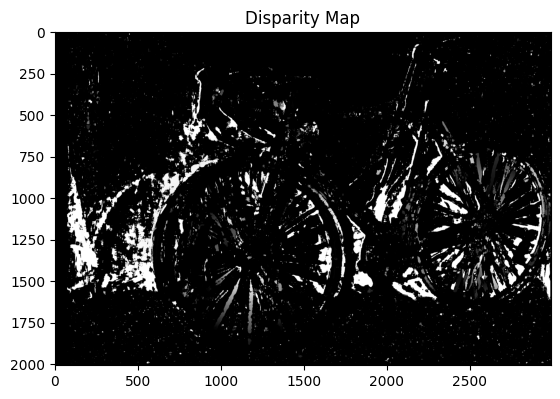

In [55]:
# Initialize the StereoBM object
stereo = cv2.StereoBM_create()

# Compute the disparity map
disparity = stereo.compute(I1, I2)

# Normalize the disparity map
disparity_normalized = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Display the disparity map
plt.imshow(disparity_normalized, cmap='gray')
plt.title('Disparity Map')
plt.show()

/tmp/ipykernel_10237/1595038435.py:4: RuntimeWarning: divide by zero encountered in divide
  depth_map = (baseline * focal_length) / disparity


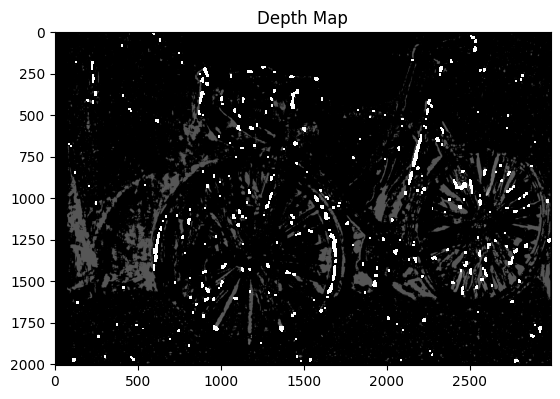

In [56]:
# Compute the focal length
focal_length = K1[0, 0]
# Compute the depth map
depth_map = (baseline * focal_length) / disparity

# Display the depth map
plt.imshow(depth_map, cmap='gray')
plt.title('Depth Map')
plt.show()

In [57]:
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [58]:
#Projection matrix calculation done on paper

T_1 = 1/T
Q = np.array([[1,0,0,-1*cx],
             [0,1,0,-1*cy],
             [0,0,1,f],
             [0,0,-1*T_1,(cx-cx_1)*T_1]],dtype=np.float32)
Q

array([[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00, -1.2638180e+03],
       [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, -9.7776300e+02],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  5.2993130e+03],
       [ 0.0000000e+00,  0.0000000e+00, -5.6405398e-03, -9.8250306e-01]],
      dtype=float32)

In [59]:
# Generate point cloud 
h,w = I2.shape[:2]
disparity = np.float32(np.divide(disparity,16.0))
points_3D = cv2.reprojectImageTo3D(disparity, Q, handleMissingValues=False)
colors = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)
mask_map = disparity > disparity.min()
output_points = points_3D[mask_map]
output_colors = colors[mask_map]


#Define name for output file
output_file = 'reconstructed.ply'

#Generate point cloud 
print ("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)


 Creating the output file... 



In [60]:
import open3d as o3d
prc_ply = o3d.io.read_point_cloud("reconstructed.ply")
o3d.visualization.draw_geometries([prc_ply])